# Finite Difference Model

Use Finite Difference method to value an option.

The underlying code used is based on the fd_runner method [here](https://github.com/domokane/CompFin/blob/main/Week%204/xladdin/Utility/kBlack.cpp)

In [25]:
from copy import copy
from math import log, sqrt, exp
from scipy.stats import norm

import numpy as np
import matplotlib.pyplot as plt

from financepy.models.finite_difference import (
    fn_dx, fn_dxx, fd_roll_backwards, fd_roll_forwards, black_scholes_fd)
from financepy.utils.math import band_matrix_multiplication, solve_tridiagonal_matrix
from financepy.utils.date import Date
from financepy.utils.global_types import OptionTypes
from financepy.products.equity.equity_vanilla_option import EquityVanillaOption
from financepy.market.curves.discount_curve_flat import DiscountCurveFlat

In [26]:
stock_price     = 100.0          # Spot S0
strike_price    = 100.0          # Strike K
volatility      = 0.20           # Sigma (annualized)
interest_rate   = 0.03           # r (continuous)
dividend_yield  = 0.00           # q (continuous)
time_to_expiry  = 0.75           # T in years
opt_type        = "call"         # "call" or "put" (or your OptionTypes enum)
num_time_steps  = 500
num_samples     = 400            # spatial grid density (your function adds +1 internally)
num_std         = 5              # domain width in log-space
theta           = 0.5            # 0=explicit, 1=implicit, 0.5=Crank–Nicolson
wind            = 0              # upwind control (your function’s convention)
digital         = False
smooth          = False
update          = False


In [27]:
s, v_grid, v_center = black_scholes_fd(
    spot_price=stock_price,
    volatility=volatility,
    time_to_expiry=time_to_expiry,
    strike_price=strike_price,
    risk_free_rate=interest_rate,
    dividend_yield=dividend_yield,
    opt_type=opt_type,
    num_time_steps=num_time_steps,
    num_samples=num_samples,
    num_std=num_std,
    theta=theta,
    wind=wind,
    digital=digital,
    smooth=smooth,
    update=update,
    return_grid=True,   # important for plotting
)


In [28]:
def bs_price(spot, K, r, q, sigma, T, opt_type="call"):
    if T <= 0 or sigma <= 0:
        return max(spot - K, 0.0) if opt_type.lower().startswith("c") else max(K - spot, 0.0)
    d1 = (log(spot / K) + (r - q + 0.5 * sigma * sigma) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    if opt_type.lower().startswith("c"):
        return spot * exp(-q * T) * norm.cdf(d1) - K * exp(-r * T) * norm.cdf(d2)
    else:
        return K * exp(-r * T) * norm.cdf(-d2) - spot * exp(-q * T) * norm.cdf(-d1)


In [ ]:
# FD price at the *actual* spot (interpolate on the geometric grid)
v_fd_at_spot = float(np.interp(stock_price, s, v_grid))

# Black–Scholes curve over the same S-grid + value at spot
bs_curve = np.array([bs_price(si, strike_price, interest_rate, dividend_yield,
                              volatility, time_to_expiry, opt_type) for si in s])

v_bs_at_spot = bs_price(stock_price, strike_price, interest_rate,
                        dividend_yield, volatility, time_to_expiry, opt_type)


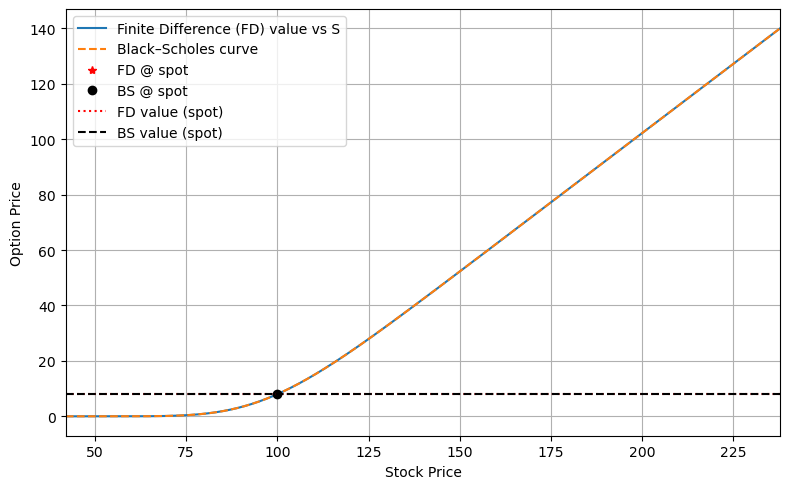

FD @ spot: 7.99370437
BS @ spot: 7.99427539
Abs error: 5.710208e-04


In [31]:
plt.figure(figsize=(8, 5))
plt.plot(s, v_grid, label="Finite Difference (FD) value vs S")     # FD curve
plt.plot(s, bs_curve, linestyle="--", label="Black–Scholes curve") # BS curve

# Mark spot values
plt.plot(stock_price, v_fd_at_spot, "r*", label="FD @ spot")
plt.plot(stock_price, v_bs_at_spot, "ko", label="BS @ spot")

# Reference lines (optional)
plt.hlines(v_fd_at_spot, s[0], s[-1], colors="r", linestyles="dotted", label="FD value (spot)")
plt.hlines(v_bs_at_spot, s[0], s[-1], colors="k", linestyles="dashed", label="BS value (spot)")

plt.xlabel("Stock Price")
plt.ylabel("Option Price")
plt.xlim((s[0], s[-1]))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# 5) Diagnostics
# -----------------------------
print(f"FD @ spot: {v_fd_at_spot:.8f}")
print(f"BS @ spot: {v_bs_at_spot:.8f}")
print(f"Abs error: {abs(v_fd_at_spot - v_bs_at_spot):.6e}")